In [ ]:
%%shell
# Inspred by https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/postgresql.ipynb#scrollTo=YUj0878jPyz7
sudo apt-get -y -qq update
sudo apt-get -y -qq install postgresql-14
# Start postgresql server
sudo sed -i "s/port = 5432/port = 5433/g" /etc/postgresql/14/main/postgresql.conf
sudo service postgresql start
# Set password
sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'pyqrlew-db'"
# Install python packages
pip install -U pip
pip install -U pyqrlew pandas graphviz matplotlib

In [11]:
import pyqrlew as qrl
from pyqrlew.io import PostgreSQL

DB = PostgreSQL()
DATASET = DB.extract()

Error response from daemon: network with name qrlew-net already exists


# Utils

In [12]:
from graphviz import Source
from IPython.display import display

def display_dot(dot_graph):
    # graph = Source(dot_graph)

    # # # Set the size of the graph
    # # graph.graph_attr['size'] = '8,6'  # Adjust the width and height as needed

    # # # Render the graph to a PNG image
    # # graph.format = 'png'
    # graph.render(filename='graph', format='png', cleanup=True)

    # # Display the graph image with a specific size
    # display(Image(filename='graph.png', width=1600))
    display(Source(dot_graph))

['extract.beacon']
SELECT * FROM extract.beacon


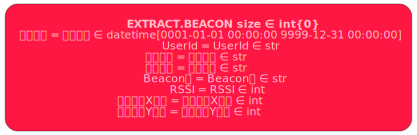

['extract.census']
SELECT * FROM extract.census


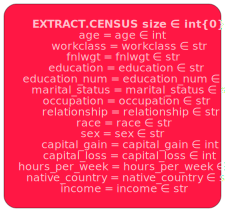

In [13]:
for p,rel in DATASET.relations():
    print(p)
    print(rel.render())
    display_dot(rel.dot())


In [14]:
MAGENTA_COLOR = '\033[35m'
BLUE_COLOR = '\033[34m'
RESET_COLOR = '\033[0m'

def print_query(query: str):
    keywords = ["SELECT", "AS", "GROUP BY", "LIMIT", "ORDER BY", "WHERE"]
    colored_query = query
    colored_query = colored_query.replace("WITH", "WITH\n ")
    colored_query = colored_query.replace(" SELECT", "\nSELECT")
    colored_query = colored_query.replace("),", "),\n ")
    for word in keywords:
        colored_query = colored_query.replace(word, MAGENTA_COLOR + word + RESET_COLOR)
    colored_query = colored_query.replace("WITH", BLUE_COLOR + "WITH" + RESET_COLOR)
    print(colored_query)

print_query("WITH customers AS (SELECT * FROM table) SELECT * FROM customers WHERE age > 25")

WITH
  customers AS (SELECT * FROM table)
SELECT * FROM customers WHERE age > 25


In [15]:
import json
from termcolor import colored

def to_json(str_schema: str):
    str_schema_to_json = str_schema.replace(" ", "")
    str_schema_to_json = str_schema_to_json.replace("{", '{"')
    str_schema_to_json = str_schema_to_json.replace(":", '":"')
    str_schema_to_json = str_schema_to_json.replace(",", '","')
    str_schema_to_json = str_schema_to_json.replace("}", '"}')
    return json.loads(str_schema_to_json)

def print_colored_json(json_data):
    formatted_json = json.dumps(json_data, indent=4)
    colored_json = highlight_keywords(formatted_json)
    print(colored_json)

def highlight_keywords(json_string):
    keywords = {
        "_PROTECTED_ENTITY_ID_": "red",
        "_PROTECTED_ENTITY_WEIGHT_": "red",
        "option": "yellow",
        "float": "blue",
        "int": "blue"
    }
    for keyword, color in keywords.items():
        json_string = json_string.replace(keyword, colored(keyword, color))
    return json_string

def print_schema(str_schema: str):
    json_obj = to_json(str_schema)
    print_colored_json(json_obj)

str_schema = '{_PROTECTED_ENTITY_ID_: option(str), _PROTECTED_ENTITY_WEIGHT_: int[0 1469283], field_l_2l: float[0 2468395440]}'

print_schema(str_schema)

{
    "_PROTECTED_ENTITY_ID_": "option(str)",
    "_PROTECTED_ENTITY_WEIGHT_": "int[01469283]",
    "field_l_2l": "float[02468395440]"
}


In [16]:
import pandas as pd
from sqlalchemy import text

def execute_query(database: PostgreSQL, query: str) -> pd.DataFrame:
    str_query = text(query)
    with database.engine().connect() as conn:
        res = conn.execute(str_query)
        names = res.keys()
    return pd.DataFrame([{name:col for name, col in zip(names, row)} for row in res])

execute_query(DB, "SELECT * FROM extract.census LIMIT 5")

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [17]:
# Relations can be evaluated directly too
path, census = DATASET.relations()[1]
pd.DataFrame(DB.eval(census))

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90.0,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82.0,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66.0,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54.0,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41.0,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,31.0,Private,327825,HS-grad,9,Separated,Machine-op-inspct,Unmarried,White,Female,0,2238,40,United-States,<=50K
195,28.0,Private,129460,10th,6,Widowed,Adm-clerical,Unmarried,White,Female,0,2238,35,United-States,<=50K
196,23.0,Self-emp-not-inc,258298,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Male,0,2231,40,United-States,>50K
197,49.0,Local-gov,102359,9th,5,Widowed,Handlers-cleaners,Unmarried,White,Male,0,2231,40,United-States,>50K


In [18]:
import matplotlib.pyplot as plt

def plot_hist(true_value, data, query):
    plt.axvline(true_value, color='red', label='True')
    for e, d in data.items():
        plt.hist(d, bins=10, alpha=0.5, label = f'eps = {e}')
    plt.legend()
    plt.title(query)

In [19]:
N_RUNS = 100

def run(dataset, query, epsilons):
    data = {}
    str_pe = """
    {
    "protected_entity": [
        ["stores", [["store", "features", "store"]], "id"],
        ["features", [], "id"],
        ["sales", [], "id"]
    ]
    }
    """
    delta  = 1e-1
    relation = dataset.sql(query)
    for epsilon in epsilons: 
        dp_relation = relation.dp_compilation(
            dataset,
            str_pe,
            epsilon, 
            delta
        )
        dp_query = dp_relation.render()
        data[epsilon] = [
            execute_query(dp_query)["my_sum"][0] for _ in range(N_RUNS)
        ]
    return data